<a href="https://colab.research.google.com/github/Andrea-1704/AML-labs/blob/main/lab%203/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torch

In [1]:
!pip3 install 'tqdm'
!pip3 install "colorama"

import torch
#use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'
print(DEVICE)

cuda:0


# Download Dataset GTEA61

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
import sys, os

#1YKfdhB9Xxh4pmND1V3gcm3Gyjc8v8idq
if not os.path.isfile('/content/drive/MyDrive'):
  #!gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content//drive/MyDrive/GTEA61.zip" > /dev/null 2>&1

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 > /dev/null 2>&1 # 3-5 min


Mounted at /content/drive


In [4]:
!git clone "https://github.com/plana93/Homework_AIML.git" > /dev/null 2>&1
#!rm -r "/content/Homework_AIML"

In [5]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torchvision
!p
from colorama import init
from colorama import Fore, Back, Style

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append("/content/Homework_AIML/")
import Homework_AIML
from Homework_AIML import *

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)


/bin/bash: line 1: p: command not found


#**Learning without Temporal information** (avgpool)

#MAIN PARAMs

# homework_step

E' una variabile che ci serve per indicare che tipo di rete andiamo ad usare.

In [37]:
#homework_step = 0 #--> Learning without Temporal information (avgpool)
#homework_step = 1 #--> Learning with Temporal information (LSTM)
homework_step = 2 #--> Learning with Spatio-Temporal information (ConvLSTM)



DATA_DIR = '/content/GTEA61/' #path dataset
model_folder = '/content/saved_models/' + "/" + "homework_step"+ str(homework_step) + "/" #path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)


# All this param can be change!

NUM_CLASSES = 61
BATCH_SIZE = 64
LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 50     # Total number of training epochs (iterations over dataset)
STEP_SIZE = [25, 75, 150] # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
MEM_SIZE = 512       # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 3          # Num Frames

# this dictionary is needed for the logger class
parameters = {'DEVICE':DEVICE, 'NUM_CLASSES':NUM_CLASSES, 'BATCH_SIZE':BATCH_SIZE,
             'LR':LR, 'MOMENTUM':MOMENTUM, 'WEIGHT_DECAY':WEIGHT_DECAY, 'NUM_EPOCHS':NUM_EPOCHS,
             'STEP_SIZE':STEP_SIZE, 'GAMMA':GAMMA, 'MEM_SIZE':MEM_SIZE, 'SEQ_LEN':SEQ_LEN}

#Dataloaders & Preprocessing

In [29]:
# Normalize
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                             ToTensor(), normalize])
spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])


In [30]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split='train', transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split='test', transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


['S2', 'S3', 'S4', 'S1']
['S2', 'S3', 'S4', 'S1']
Train Dataset: 341
Test Dataset: 116


#Model

Ricorda che flatten lo faccio dopo le convoluzioni prima delle Fully connected.

LSTM ha dei parametri che metti nella init.

Nota che se fai scelte strane devi metterlo nel report.

In [31]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

# LSTM definition

In [32]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable



# LSTM
class MyLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        super(MyLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Definisci layer lineari per ciascun gate
        self.W_i = nn.Linear(input_size, hidden_size)  # input gate
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_f = nn.Linear(input_size, hidden_size)  # forget gate
        self.U_f = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_c = nn.Linear(input_size, hidden_size)  # cell state update
        self.U_c = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_o = nn.Linear(input_size, hidden_size)  # output gate
        self.U_o = nn.Linear(hidden_size, hidden_size, bias=False)

        # Funzioni di attivazione
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))

        h_prev, c_prev = state

        # Calcolo del gate di ingresso (input gate)
        i = self.sigmoid(self.W_i(x) + self.U_i(h_prev))

        # Calcolo del gate di dimenticanza (forget gate)
        f = self.sigmoid(self.W_f(x) + self.U_f(h_prev))

        # Calcolo dell'aggiornamento dello stato della cella (cell update)
        g = self.tanh(self.W_c(x) + self.U_c(h_prev))

        # Calcolo del gate di output
        o = self.sigmoid(self.W_o(x) + self.U_o(h_prev))

        # Aggiorna lo stato della cella
        c_next = f * c_prev + i * g

        # Aggiorna lo stato nascosto
        h_next = o * self.tanh(c_next)

        # Ritorna il nuovo stato nascosto e lo stato della cella
        return h_next, c_next


Nota che tramite la funzione __nn.Linear(in_features, out_features, bias)__ stiamo definendo un livello di rete neurale di tipo Fully connected. Questo livello presenta in_features neuroni in ingresso e out_features neuroni in uscita e l'eventuale bias se specificato (bias è una variabile booleana).

Per capire il perché di queste formule rivedi come è definita internamente la rete neurale LSTM:





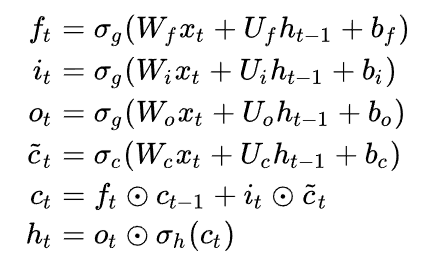

## Perché specifico il bias solo per alcuni livelli?
Perché nella formula il prodotto Wfxt e Ufht-1 (per esempio) usano lo stesso bias (vedi il calcolo di ft).
Pytorch ci fa scrivere il codice come se fossero due livelli differenti (perché lo sono) ma usano lo steso bias.

Quindi quando scrivi:
        self.W_i = nn.Linear(input_size, hidden_size)  # input gate
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=False)
Qui usiamo lo stesso bias bf per il calcolo.

Come noti qui:



```
def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))

        h_prev, c_prev = state

        # Calcolo del gate di ingresso (input gate)
        i = self.sigmoid(self.W_i(x) + self.U_i(h_prev))

        # Calcolo del gate di dimenticanza (forget gate)
        f = self.sigmoid(self.W_f(x) + self.U_f(h_prev))

        # Calcolo dell'aggiornamento dello stato della cella (cell update)
        g = self.tanh(self.W_c(x) + self.U_c(h_prev))

        # Calcolo del gate di output
        o = self.sigmoid(self.W_o(x) + self.U_o(h_prev))

        # Aggiorna lo stato della cella
        c_next = f * c_prev + i * g

        # Aggiorna lo stato nascosto
        h_next = o * self.tanh(c_next)

        # Ritorna il nuovo stato nascosto e lo stato della cella
        return h_next, c_next
```



 si tratta davvero solo di applicare la definizione delle formule sopra riportate.

#Conv LSTM

In [11]:
#ConvLSTM
class MyConvLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        # Se non viene passato uno stato, inizializzalo a zero
        if state is None:
            h_prev = torch.zeros(x.size(0), self.hidden_size, x.size(2), x.size(3), device=x.device)
            c_prev = torch.zeros(x.size(0), self.hidden_size, x.size(2), x.size(3), device=x.device)
        else:
            h_prev, c_prev = state

        # Calcolo del gate di ingresso (input gate)
        i = torch.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(h_prev))

        # Calcolo del gate di dimenticanza (forget gate)
        f = torch.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(h_prev))

        # Calcolo dell'aggiornamento dello stato della cella (cell update)
        g = torch.tanh(self.conv_c_xx(x) + self.conv_c_hh(h_prev))

        # Calcolo del gate di output
        o = torch.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(h_prev))

        # Aggiorna lo stato della cella
        c_next = f * c_prev + i * g

        # Aggiorna lo stato nascosto
        h_next = o * torch.tanh(c_next)

        # Ritorna il nuovo stato nascosto e lo stato della cella
        return h_next, c_next


Il convolutional LSTM è esattamente come lstm ma con la differenza che invece di utilizzare nn.Linear usa dei livelli convoluzionali.

# Final model

In [12]:
#Network
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step = 0 , DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
          self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
          self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)
    def forward(self, inputVariable):
        #Learning without Temporal information (mean)
        if self.homework_step == 0:
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            state = ( torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE) )
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE))
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

Qui definiamo il cuore del modello. Controllando una variabile chiamata __homework_step__ andiamo ad indicare se vogliamo applicare:



1.   ResNet34 (per le immagini) + average pooling + fully connected
2.   ResNet34 (per le immagini) + average pooling + LSTM + fully connected
3.   ResNet34 (per le immagini) + ConvLSTM + fully connected

Nota che ci serve un average pooling per passare da livelli convoluzionali a livelli fully connected.

Il fully connected ci serve per fare la predizione. Inoltre nota che eseguiamo Dropout come metodo di regolarizzazione.

#Build Model - Loss - Opt

In [38]:
#CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model

#Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)


model = model.to(DEVICE)

#model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)


#Loss
loss_fn = nn.CrossEntropyLoss()
#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Qui congelo la backbone.

Nota che infatti con:


```
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)
```
Stiamo dicendo che vogliamo congelare la backbone, ovvero la resnet, e addestrare solo lstm e il livello FC.


#Training


In [35]:
import warnings
warnings.filterwarnings('ignore')

train_iter = 0
val_iter = 0
min_accuracy = 0

trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
val_samples = len(test_dataset)
iterPerEpoch = len(train_loader)
val_steps = len(val_loader)
cudnn.benchmark
model_checkpoint = "model" #name


for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0

    #blocks to train
    if homework_step > 0:
        model.lstm_cell.train(True)
    model.classifier.train(True)


    for i, (inputs, targets) in enumerate(train_loader):
        train_iter += 1
        optimizer_fn.zero_grad()

        # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        # feeds in model
        output_label, _ = model(inputVariable)

        # compute loss
        loss = loss_fn(output_label, labelVariable)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_label.data, 1)
        numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
        step_loss = loss.data.item()
        epoch_loss += step_loss

    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples) * 100
    #train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)
    print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))
    if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()
                #val_logger.add_step_data(val_iter, numCorr, val_loss_step)

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

    optim_scheduler.step()

print(Fore.CYAN + "Best Acc --> ", min_accuracy)
print(Fore.CYAN + "Last Acc --> ", val_accuracy)


Train: Epoch = 1 | Loss = 4.339 | Accuracy = 1.562


KeyboardInterrupt: 

#Test

In [ ]:
model.train(False)
val_loss_epoch = 0
numCorr = 0
val_iter = 0
val_samples = len(test_dataset)
val_steps = len(val_loader)

with torch.no_grad():
    for j, (inputs, targets) in enumerate(val_loader):
        val_iter += 1
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        output_label, _ = model(inputVariable)
        val_loss = loss_fn(output_label, labelVariable)
        val_loss_step = val_loss.data.item()
        val_loss_epoch += val_loss_step
        _, predicted = torch.max(output_label.data, 1)
        numCorr += torch.sum(predicted == labelVariable.data).data.item()

    val_accuracy = (numCorr / val_samples) * 100
    avg_val_loss = val_loss_epoch / val_steps

print('Loss {:.3f} | Accuracy = {:.3f}'.format(avg_val_loss, val_accuracy))

# Load the pretrained-weights





In [39]:
#CUDA_LAUNCH_BLOCKING=1
validate = True
model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model
#Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

for params in model.lstm_cell.parameters():
    params.requires_grad = True
model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)

model = model.to(DEVICE)
model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)


#Loss
loss_fn = nn.CrossEntropyLoss()
#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)



Tramite la riga:


```
model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)

```

Stiamo andando a caricare i parametri della rete per la backbone (in realtà per tutta la rete) ma quelli di convLSTM e quelli di classifier verranno cambiati visto che ne facciamo il training.

In [27]:
#training:
import warnings
warnings.filterwarnings('ignore')

train_iter = 0
val_iter = 0
min_accuracy = 0

trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
val_samples = len(test_dataset)
iterPerEpoch = len(train_loader)
val_steps = len(val_loader)
cudnn.benchmark
model_checkpoint = "model" #name


for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0

    #blocks to train
    if homework_step > 0:
        model.lstm_cell.train(True)
    model.classifier.train(True)


    for i, (inputs, targets) in enumerate(train_loader):
        train_iter += 1
        optimizer_fn.zero_grad()

        # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        # feeds in model
        output_label, _ = model(inputVariable)

        # compute loss
        loss = loss_fn(output_label, labelVariable)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_label.data, 1)
        numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
        step_loss = loss.data.item()
        epoch_loss += step_loss

    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples) * 100
    #train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)
    print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))
    if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()
                #val_logger.add_step_data(val_iter, numCorr, val_loss_step)

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

    optim_scheduler.step()

print(Fore.CYAN + "Best Acc --> ", min_accuracy)
print(Fore.CYAN + "Last Acc --> ", val_accuracy)


Train: Epoch = 1 | Loss = 4.539 | Accuracy = 9.375
Val: Epoch = 1 | Loss 2.835 | Accuracy = 21.552
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 3.413 | Accuracy = 15.313
Val: Epoch = 2 | Loss 2.593 | Accuracy = 27.586
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 2.974 | Accuracy = 21.250
Val: Epoch = 3 | Loss 2.519 | Accuracy = 27.586
Train: Epoch = 4 | Loss = 2.867 | Accuracy = 22.500
Val: Epoch = 4 | Loss 2.408 | Accuracy = 37.069
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 2.742 | Accuracy = 26.562
Val: Epoch = 5 | Loss 2.365 | Accuracy = 36.207
Train: Epoch = 6 | Loss = 2.619 | Accuracy = 27.187
Val: Epoch = 6 | Loss 2.360 | Accuracy = 37.069
Train: Epoch = 7 | Loss = 2.599 | Accuracy = 30.625
Val: Epoch = 7 | Loss 2.249 | Accuracy = 38.793
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 2.439 | Accuracy = 31.562
Val: Epoch = 8 | Loss 2.357 | Accuracy = 37.931
Train: Epoch = 9 | Loss = 2.465 | Accuracy = 32.188
Val: Epoch = 9 | Loss 2.226 | Accuracy = 39.6

Come possiamo notare questo migliora di molto le prestazioni.

# Class Activation Map (CAM)


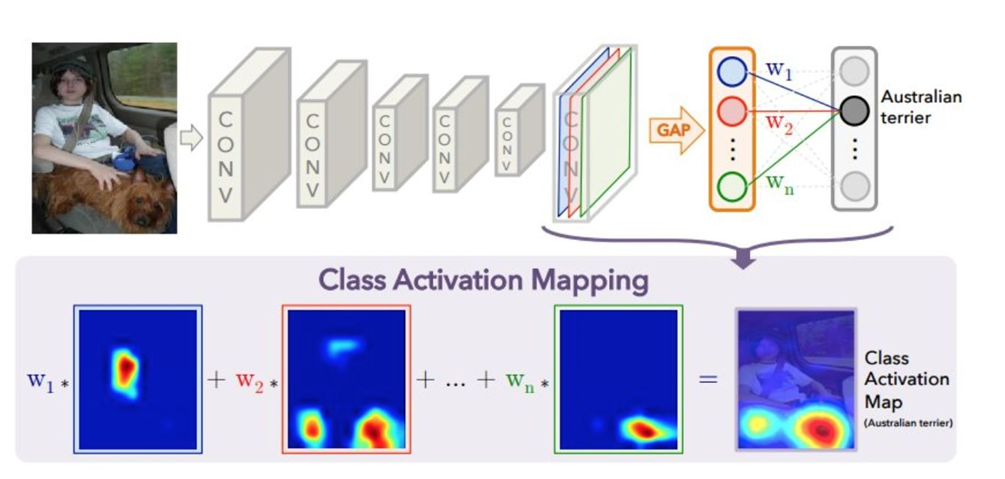